In [79]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import Counter


In [2]:
def dibujar_arbol(G, titulo,pos, node_labels):
    nx.draw(G, pos, node_size=600)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(titulo)
    plt.show()

# etiqueta el la trayectoria mas larga

In [3]:
def encontrar_trayectoria_mas_larga(G):
    def dfs_mas_lejano(nodo, visitados):
        visitados.add(nodo)
        mas_lejano = (nodo, 0)
        for vecino in G.neighbors(nodo):
            if vecino not in visitados:
                siguiente, dist = dfs_mas_lejano(vecino, visitados)
                if dist + 1 > mas_lejano[1]:
                    mas_lejano = (siguiente, dist + 1)
        return mas_lejano

    def dfs_camino(nodo, objetivo, visitados, camino):
        visitados.add(nodo)
        camino.append(nodo)
        if nodo == objetivo:
            return True
        for vecino in G.neighbors(nodo):
            if vecino not in visitados:
                if dfs_camino(vecino, objetivo, visitados, camino):
                    return True
        camino.pop()
        return False

    u, _ = dfs_mas_lejano(next(iter(G.nodes)), set())
    v, _ = dfs_mas_lejano(u, set())
    camino = []
    dfs_camino(u, v, set(), camino)
    return camino

In [4]:
def etiquetar_trayectoria_mas_larga(G):
    etiquetado = {}
    # Paso 1: Encontrar la trayectoria más larga
    camino = encontrar_trayectoria_mas_larga(G)
    for i, nodo in enumerate(camino):
        etiquetado[nodo] = i + 1  # Etiquetar los nodos de la trayectoria más larga
    return etiquetado

# genera un arbol k-ario de cierta altura

In [5]:
def generar_arbol_regular_balanceado(k=3, altura=2):
    G = nx.Graph()
    node_id = 0
    edges = []
    niveles = [[node_id]]
    node_id += 1

    for _ in range(altura):
        nivel_actual = []
        for padre in niveles[-1]:
            hijos = [node_id + i for i in range(k)]
            edges.extend((padre, h) for h in hijos)
            nivel_actual.extend(hijos)
            node_id += k
        niveles.append(nivel_actual)
    G.add_edges_from(edges)
    return G

# obtiene la trayectoria mas larga de una rama

In [6]:
def vecinos_de_conjunto(G, nodos):
    """
    Devuelve el conjunto de vecinos de un grupo de nodos, excluyendo los propios nodos.
    
    Parámetros:
        G     : grafo de networkx (puede ser dirigido o no dirigido)
        nodos : iterable de nodos (ej. lista, conjunto)

    Retorna:
        Un conjunto de nodos vecinos.
    """
    vecinos = []
    for nodo in nodos:
        vecinos.extend(list(G.neighbors(nodo)))
    vecinos  = [v for v in vecinos if v not in list(nodos)]
    return vecinos

In [7]:
def trayectoria_mas_larga_desde(G, inicio):
    """
    Encuentra la trayectoria más larga que inicia en un nodo dado.
    No considera ciclos; es un camino simple más largo desde ese nodo.

    Parámetros:
        G      : grafo no dirigido (networkx.Graph)
        inicio : nodo inicial

    Retorna:
        Una lista con los nodos en orden de la trayectoria más larga.
    """
    def dfs(nodo, visitados):
        visitados.add(nodo)
        max_camino = [nodo]
        for vecino in G.neighbors(nodo):
            if vecino not in visitados:
                camino = dfs(vecino, visitados.copy())
                if len(camino) + 1 > len(max_camino):
                    max_camino = [nodo] + camino
        return max_camino

    return dfs(inicio, set())

In [8]:
def etiqueta_trayectoria_rama(H, nodo, max_label):
    for comp in nx.connected_components(H):
        if nodo in comp:
            H_sub = H.subgraph(comp).copy()
            trayectoria = trayectoria_mas_larga_desde(H, nodo)
            i=max_label
            etiquetado = {}
            for n in trayectoria:
                i=i+1
                etiquetado[n] = i  # Etiquetar los nodos de la trayectoria más larga
            return etiquetado
    return {}

# Etiquetado recursivo

In [9]:
def etiquetado_recursivo(G):
    pila = []
    node_labels = etiquetar_trayectoria_mas_larga(G)
    #print("Etiquetas de los nodos:", node_labels)
    #Obtiene la trayectoria
    trayectoria = list(node_labels.keys())
    pila.append(trayectoria)

    j=1
    while len(pila)>0:
        #print("********* Ciclo ", j, "*************")
        j+=1

        trayectoria = pila[-1]
        #print("Pila inicial", pila)
        #print("Trayectoria", trayectoria)

        # Obtiene un grafo sin los nodos etiquetados
        H = G.copy()
        H.remove_nodes_from(trayectoria)
        #obtiene el primer vecino sin etiquetar
        vecinos_trayectoria = [n for n in vecinos_de_conjunto(G, trayectoria) if n not in list(node_labels.keys())]
        #print("Vecinos trayectoria ", list(vecinos_trayectoria))
        vecino_sin_etiqueta = vecinos_trayectoria[0]
        #print("primero sin etiqueta ", vecino_sin_etiqueta)
        #si es el unico vecino sin etiquetar remueve de la trayectoria de la pila
        if len(vecinos_trayectoria) <= 1:
            pila.pop()
    
        #obtiene la etiqueta mas grande
        max_label = max(list(node_labels.values())) 
    
        #obtiene la trayectoria más larga de la rama del vecino sin etiquetas
        etiquetas = etiqueta_trayectoria_rama(H, vecino_sin_etiqueta, max_label)
        node_labels.update(etiquetas)
        trayectoria = list(etiquetas.keys())
        #print("Nueva trayectoria ", trayectoria)
        vecinos = vecinos_de_conjunto(G, trayectoria)
        #print("Vecinos", vecinos)
        vecinos_trayectoria = [n for n in vecinos if n not in list(node_labels.keys())]
        #print("Vecinos nva trayectoria ", vecinos_trayectoria)
        #print("Etiquetas de los nodos:", node_labels)
        #Si la trayectoria tiene vecinos sin etiquetar, la coloca en la pila
        if len(vecinos_trayectoria) > 0:
            pila.append(trayectoria)
            #print("Pila final", pila)
    return node_labels

## Lee las redes

In [10]:
def prufer_sequence_from_tree(edges):
    """
    Obtiene la sucesión de Prüfer de un árbol dado.

    Parámetros:
      - edges: lista de tuplas (u, v) que representan las aristas de un árbol etiquetado.

    Retorna:
      - prufer_seq: lista que representa la sucesión de Prüfer del árbol.
    """
    # 1. Determinar el conjunto de nodos y el número total de vértices.
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    # 2. Crear la lista de adyacencia y calcular el grado de cada nodo.
    adj = {node: [] for node in nodes}
    degree = {node: 0 for node in nodes}

    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
        degree[u] += 1
        degree[v] += 1

    # 3. Inicializar un heap (min-heap) con todas las hojas (nodos con grado 1)
    heap = []
    for node in nodes:
        if degree[node] == 1:
            heapq.heappush(heap, node)

    prufer_seq = []

    # 4. Realizar n-2 iteraciones para construir la sucesión de Prüfer.
    for _ in range(n - 2):
        # a) Extraer la hoja de menor etiqueta.
        leaf = heapq.heappop(heap)

        # b) Su hoja tendrá un único vecino; se toma el primer (y único) de su lista de adyacencia.
        neighbor = adj[leaf][0]
        prufer_seq.append(neighbor)

        # c) Actualizar el grado del vecino, eliminando la conexión con la hoja.
        degree[neighbor] -= 1
        adj[neighbor].remove(leaf)

        # d) La hoja se elimina del árbol; (podríamos marcarla con grado 0).
        degree[leaf] = 0

        # e) Si el vecino ahora es una hoja (grado 1), se agrega al heap.
        if degree[neighbor] == 1:
            heapq.heappush(heap, neighbor)

    return prufer_seq

In [74]:
def muestra_secuencias(secuencias, etiquetas, titulo, xlabel, ylabel):
    # Crear figura y ejes en una cuadrícula 2x2
    fig, axes = plt.subplots(len(secuencias),1, figsize=(20, 20))
    for i, seq in enumerate(secuencias):
        axes[i].plot(seq[0], label=etiquetas[0], marker="o", linestyle="-")
        axes[i].plot(seq[1], label=etiquetas[1], marker="*", linestyle="-")
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(titulo, fontsize=16)
    fig.show()


In [33]:
PATH_NEUROESPORA = "redes/Neurospora_crassa/"
REDES_NEUROESPORA = {1:["Muestra1_M1N17h","Muestra1_M1N18h","Muestra1_M1N20h","Muestra1_M1N22h","Muestra1_M1N24h"],
    2:["Muestra2_M2N18h","Muestra2_M2N20h","Muestra2_M2N22h","Muestra2_M2N24h"],
    3:["Muestra3_M3N17h","Muestra3_M3N18h","Muestra3_M3N20h","Muestra3_M3N22h","Muestra3_M3N24h"],
    4:["Muestra4_M4N17h","Muestra4_M4N18h","Muestra4_M4N20h","Muestra4_M4N22h","Muestra4_M4N24h"],
    5:["Muestra5_M5N18h","Muestra5_M5N20h","Muestra5_M5N22h","Muestra5_M5N24h"]
}

In [29]:
PATH_TRICHODERMA = "redes/Trichoderma_atroviride/"
REDES_TRICHODERMA = {1:["Muestra1_M1T24h","Muestra1_M1T26h","Muestra1_M1T28h","Muestra1_M1T30h","Muestra1_M1T32h"],
    2:["Muestra2_M2T24h","Muestra2_M2T26h","Muestra2_M2T28h","Muestra2_M2T30h","Muestra2_M2T32h"],
    3:["Muestra3_M3T26h","Muestra3_M3T28h","Muestra3_M3T30h","Muestra3_M3T32h","Muestra3_M3T34h","Muestra3_M3T36h"],
    4:["Muestra4_M4T26h","Muestra4_M4T28h","Muestra4_M4T30h","Muestra4_M4T32h","Muestra4_M4T34h","Muestra4_M4T36h"],
    5:["Muestra5_M5T26h","Muestra5_M5T28h","Muestra5_M5T30h","Muestra5_M5T32h","Muestra5_M5T36h"]
}

In [16]:
def compute_prufer(G):
    # Procesa micelio
    print("Es árbol: ", nx.is_tree(G))
    if not nx.is_tree(G):
        T = nx.minimum_spanning_tree(G)
        node_labels = etiquetado_recursivo(T)
        G_relabelled = nx.relabel_nodes(T, node_labels, copy=True)
    else:
        node_labels = etiquetado_recursivo(G)
        G_relabelled = nx.relabel_nodes(G, node_labels, copy=True)
    ps = prufer_sequence_from_tree(G_relabelled.edges())    
    return ps

# Datos para generar secuencias aleatorias

In [30]:
nodos_trichoderma = {1: [24, 68 , 84 , 148, 294],
                    2: [8, 16, 24, 62, 150],
                    3: [14, 42, 68, 160, 356, 788],
                    4: [18,24, 50,104, 268, 606],
                    5: [14,18,42,108,422]}
nodos_neurospora = {1: [42, 54 , 102 , 226, 663 ],
                    2: [44, 110, 226, 758,],
                    3: [6, 24, 50, 128, 338],
                    4: [58, 84, 202, 518, 1578],
                    5: [48, 100, 280, 790],
                    }

**** Procesando red: Muestra1_M1T24h con 24 nodos y 24 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1T26h con 68 nodos y 70 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 68 nodos y 67 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1T28h con 84 nodos y 86 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 84 nodos y 83 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1T30h con 148 nodos y 152 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 148 nodos y 147 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1T32h con 294 nodos y 314 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 294 nodos y 293 aristas.
Es árbol:  True


/var/folders/gw/x5b6glr13clbt8md6003thh40000gn/T/ipykernel_70176/2742300556.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


**** Procesando red: Muestra2_M2T24h con 8 nodos y 7 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 8 nodos y 7 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T26h con 16 nodos y 15 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 16 nodos y 15 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T28h con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T30h con 62 nodos y 62 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 62 nodos y 61 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T32h con 150 nodos y 159 aristas.
Es árbol:  False
**** Procesando árbol aleatorio con 150 nodos y 149 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3T26h con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3T28h con 42 nodos y 41 aristas.
Es á

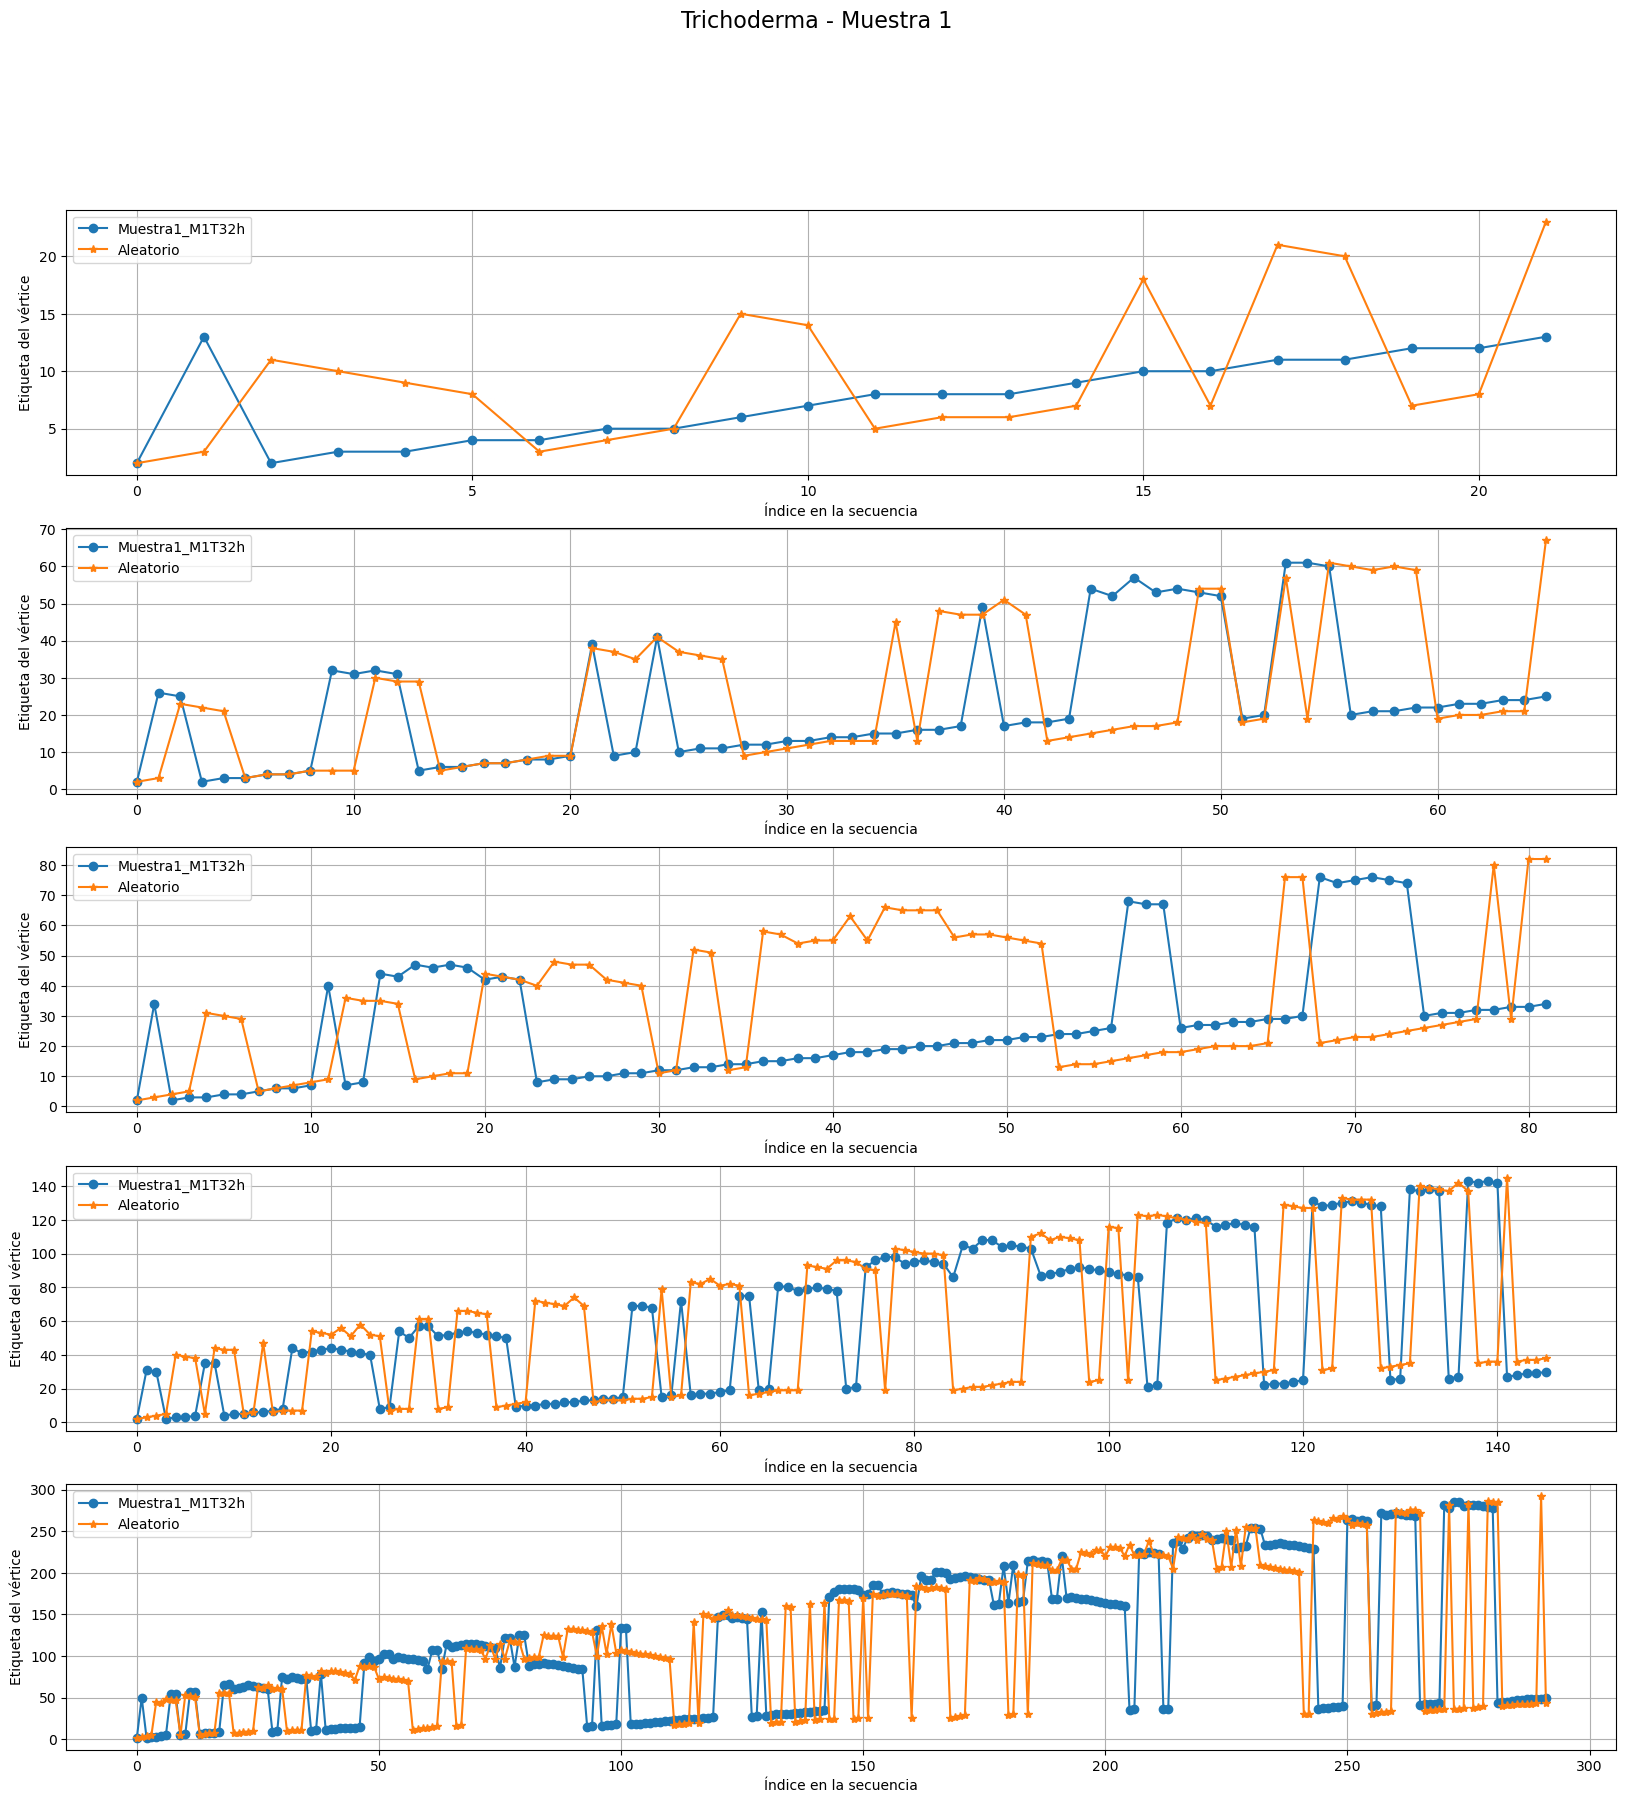

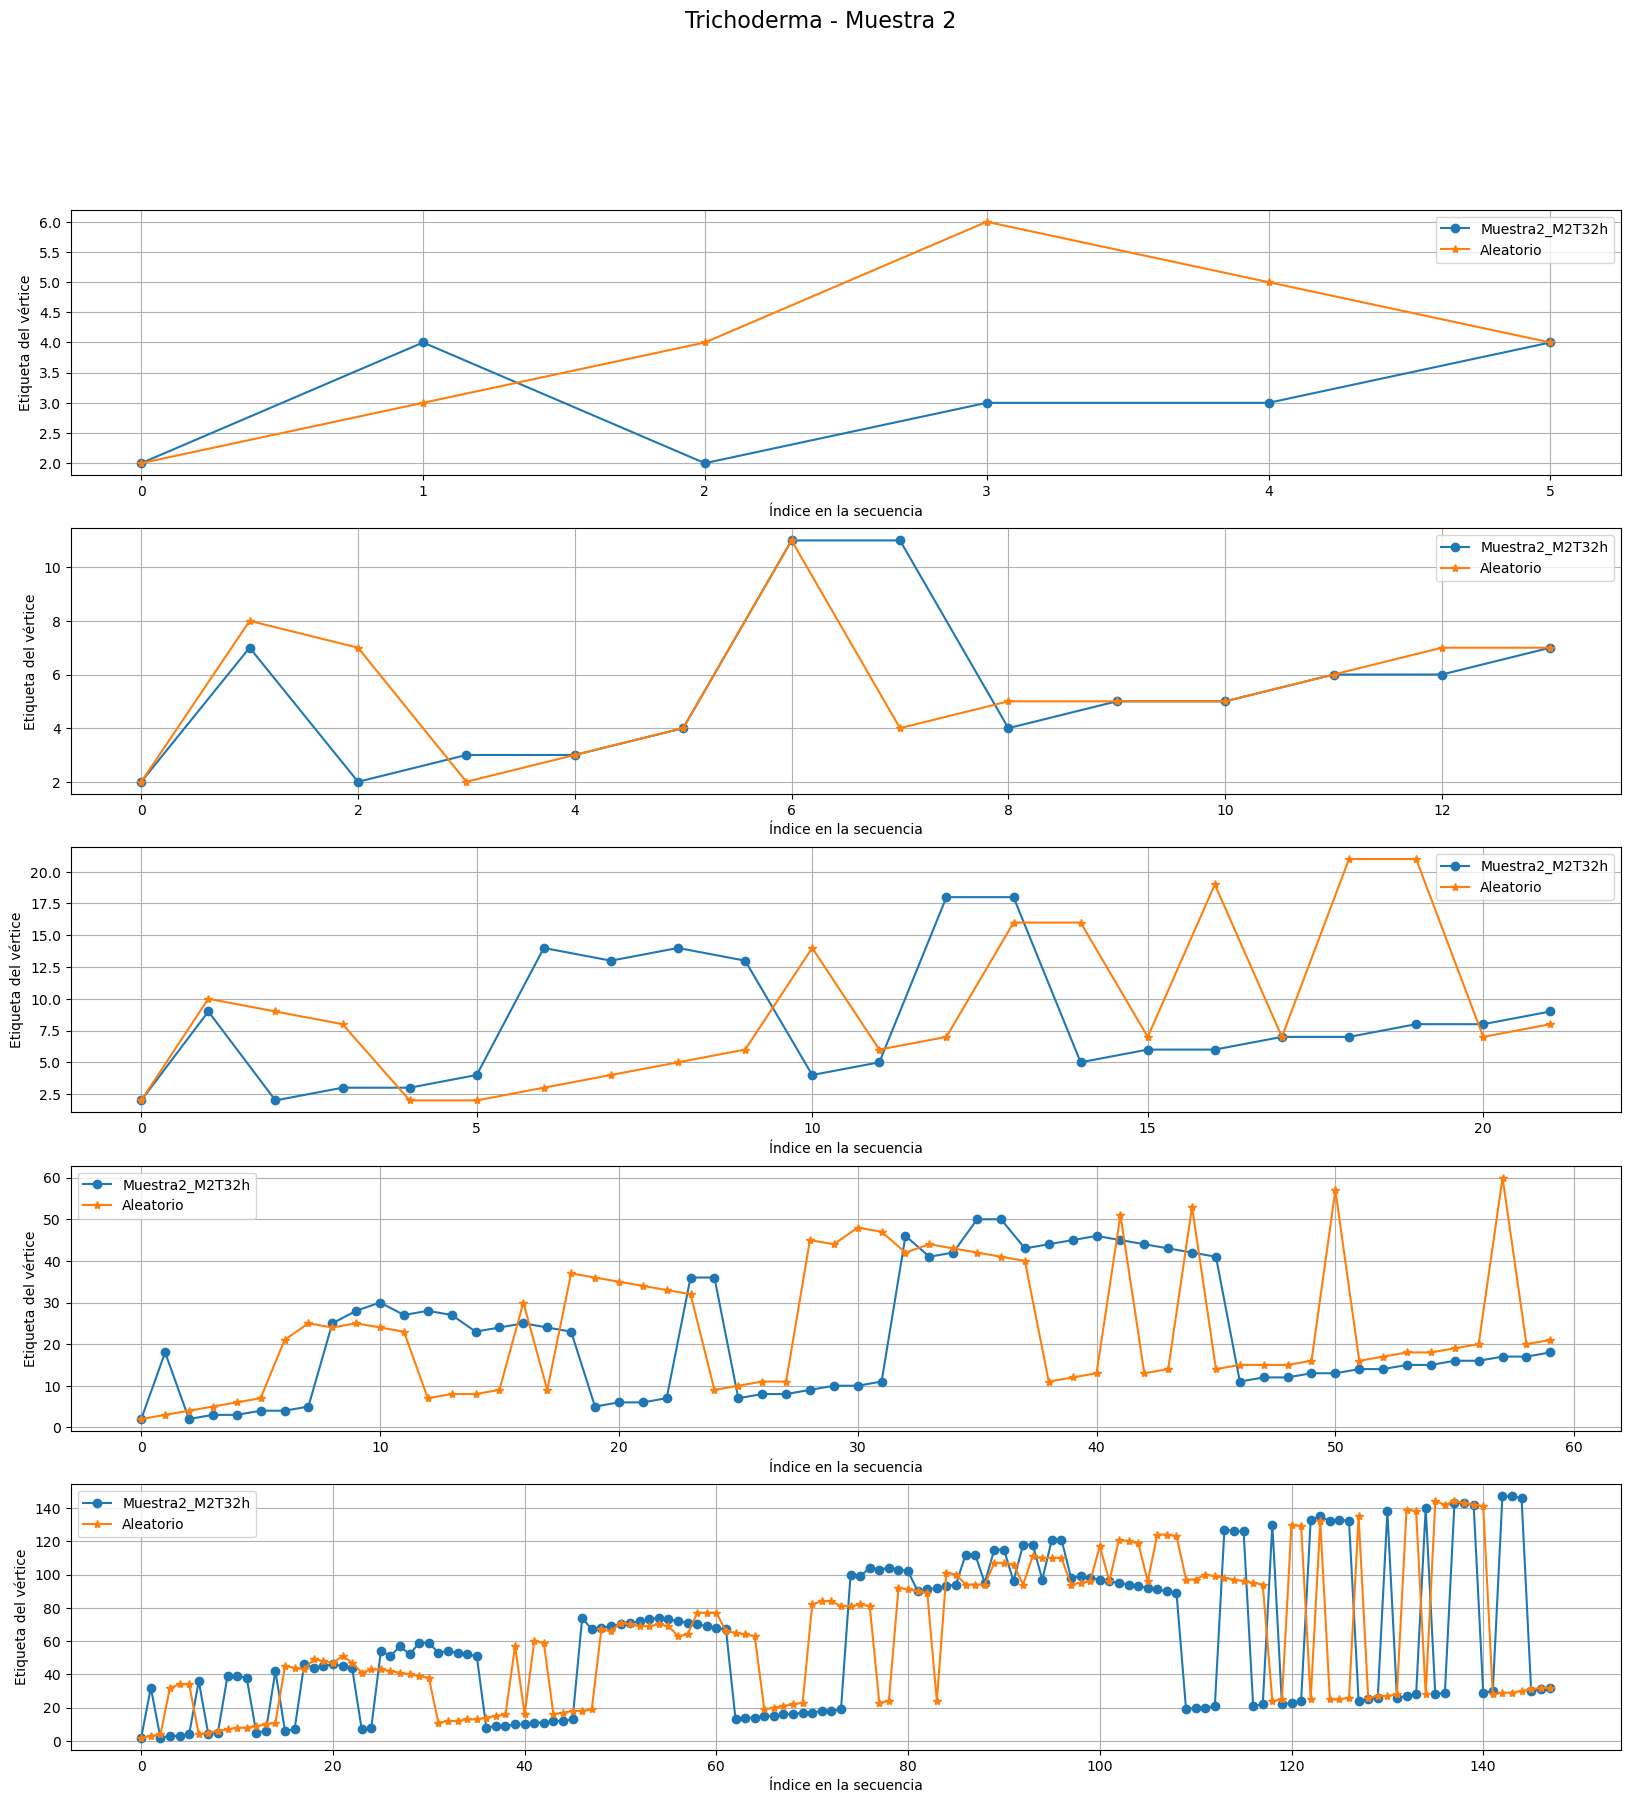

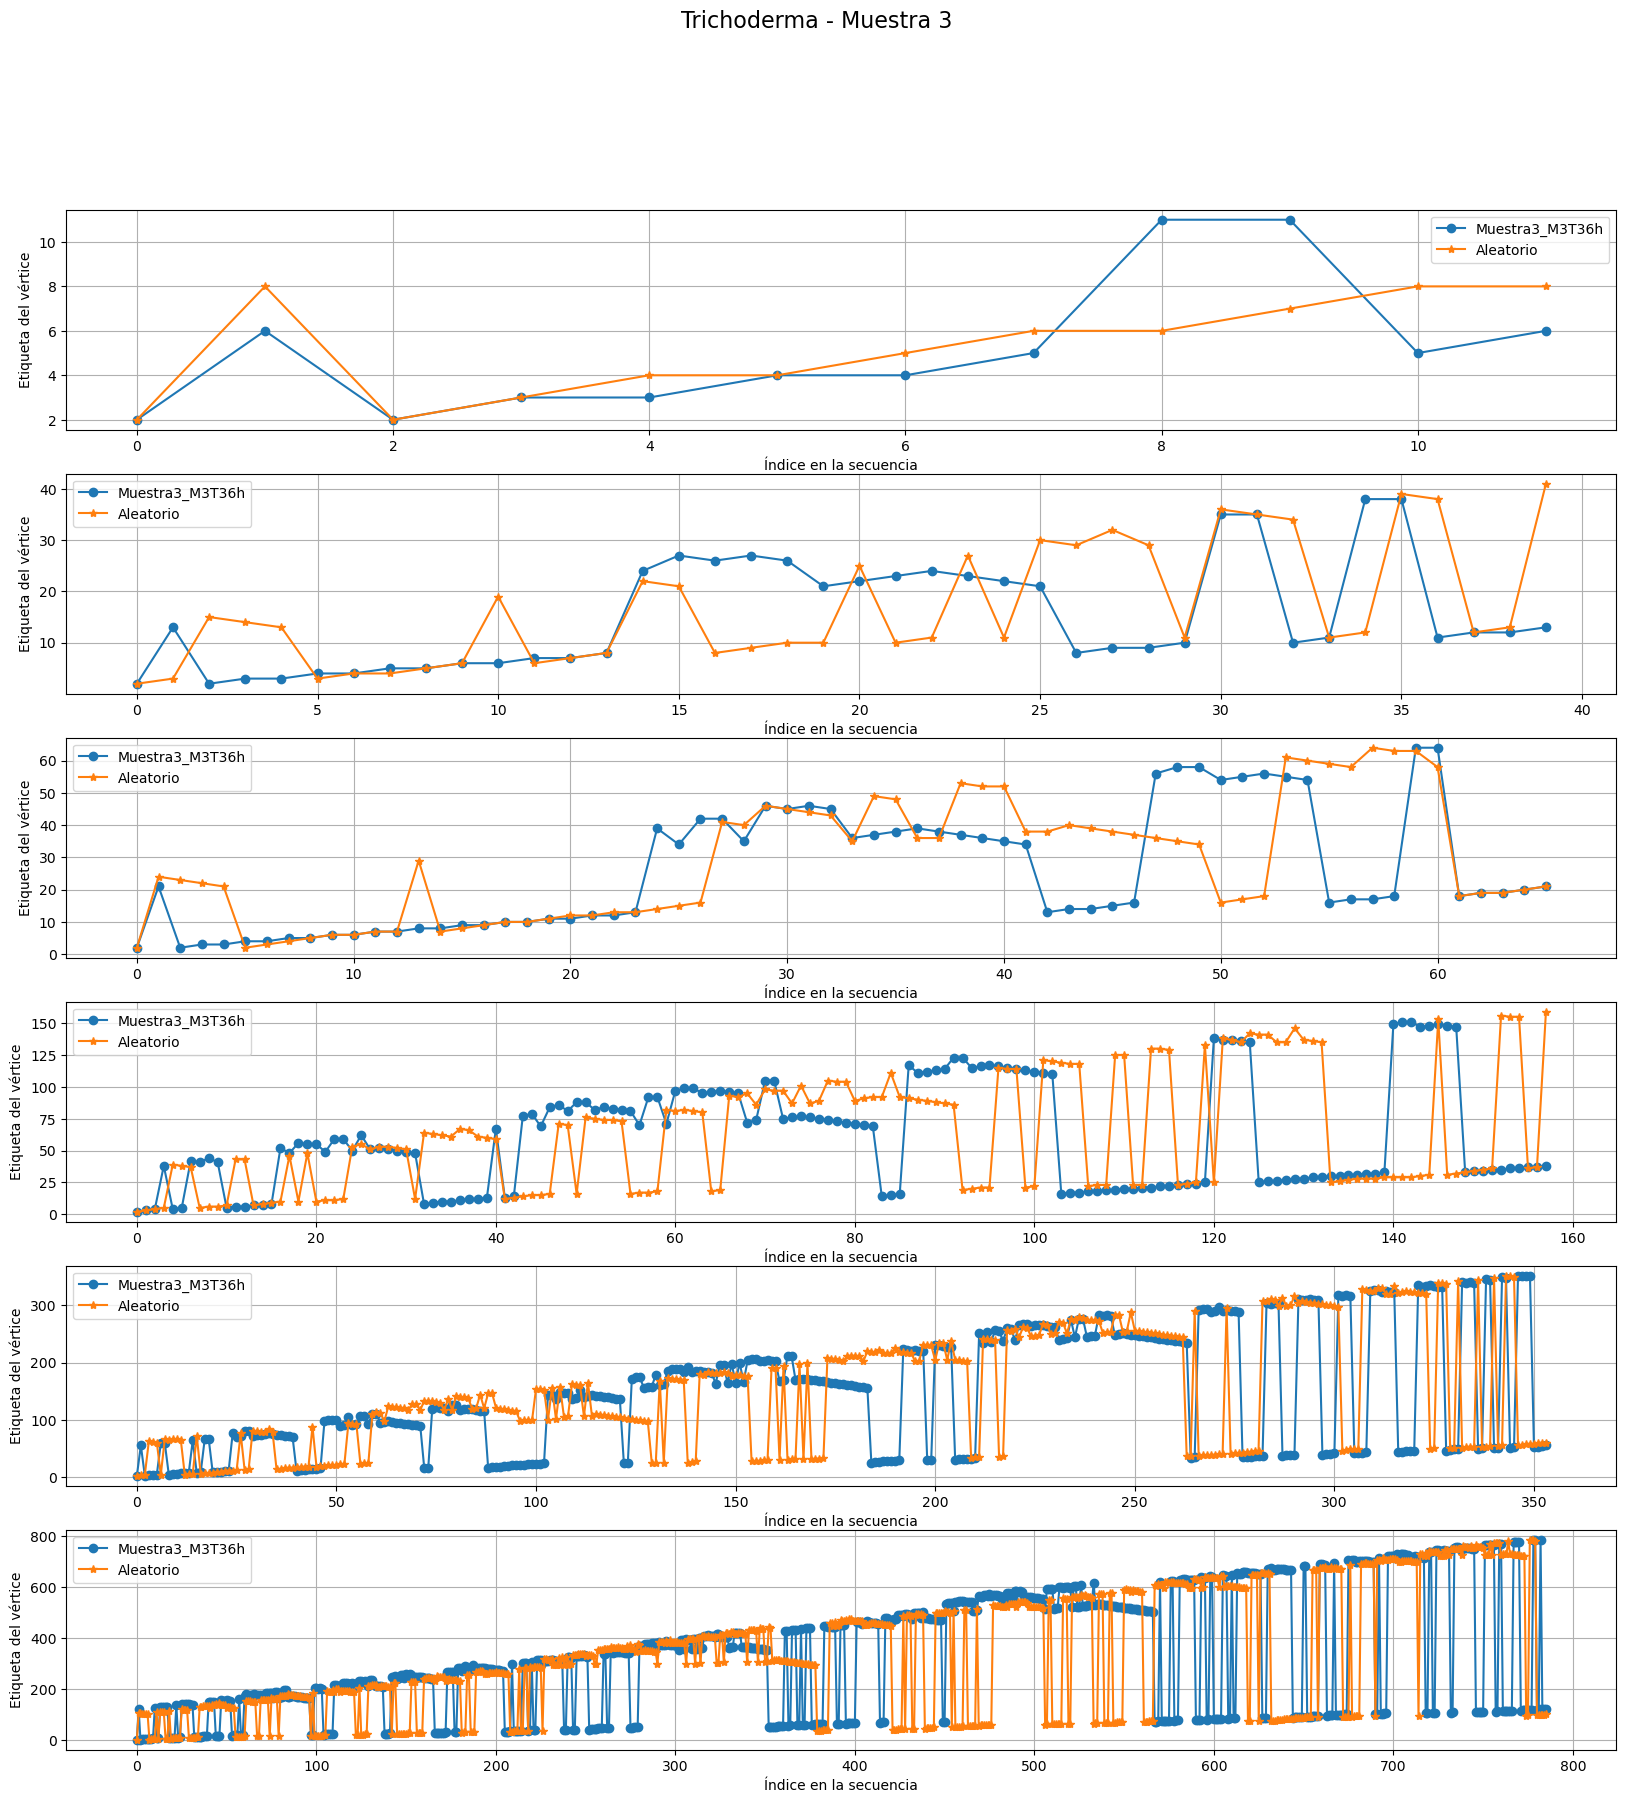

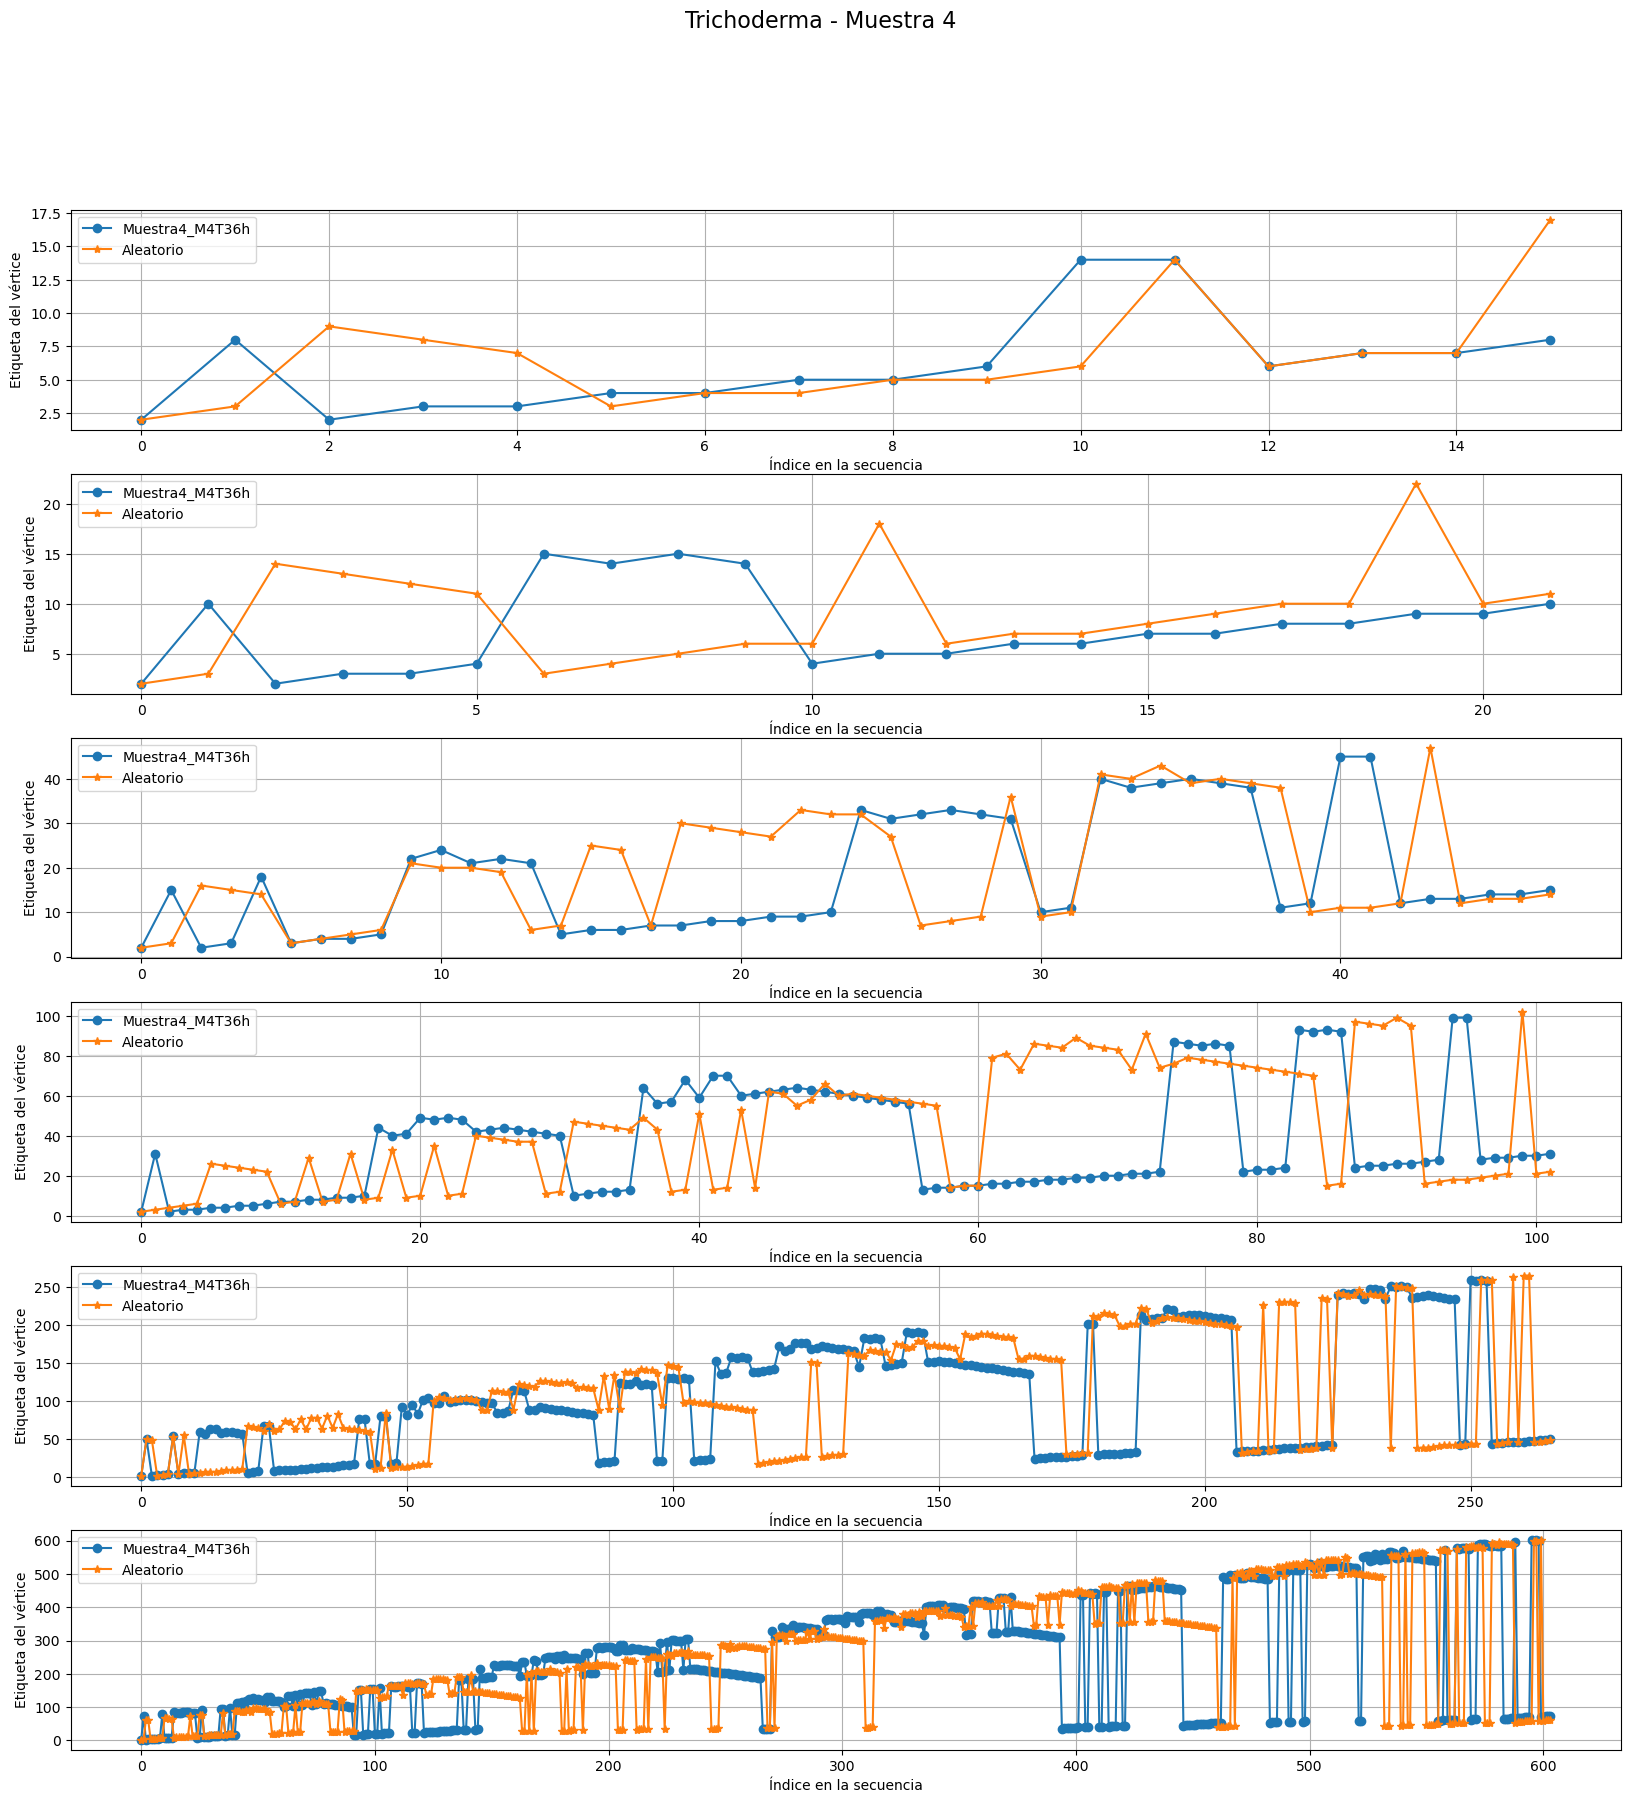

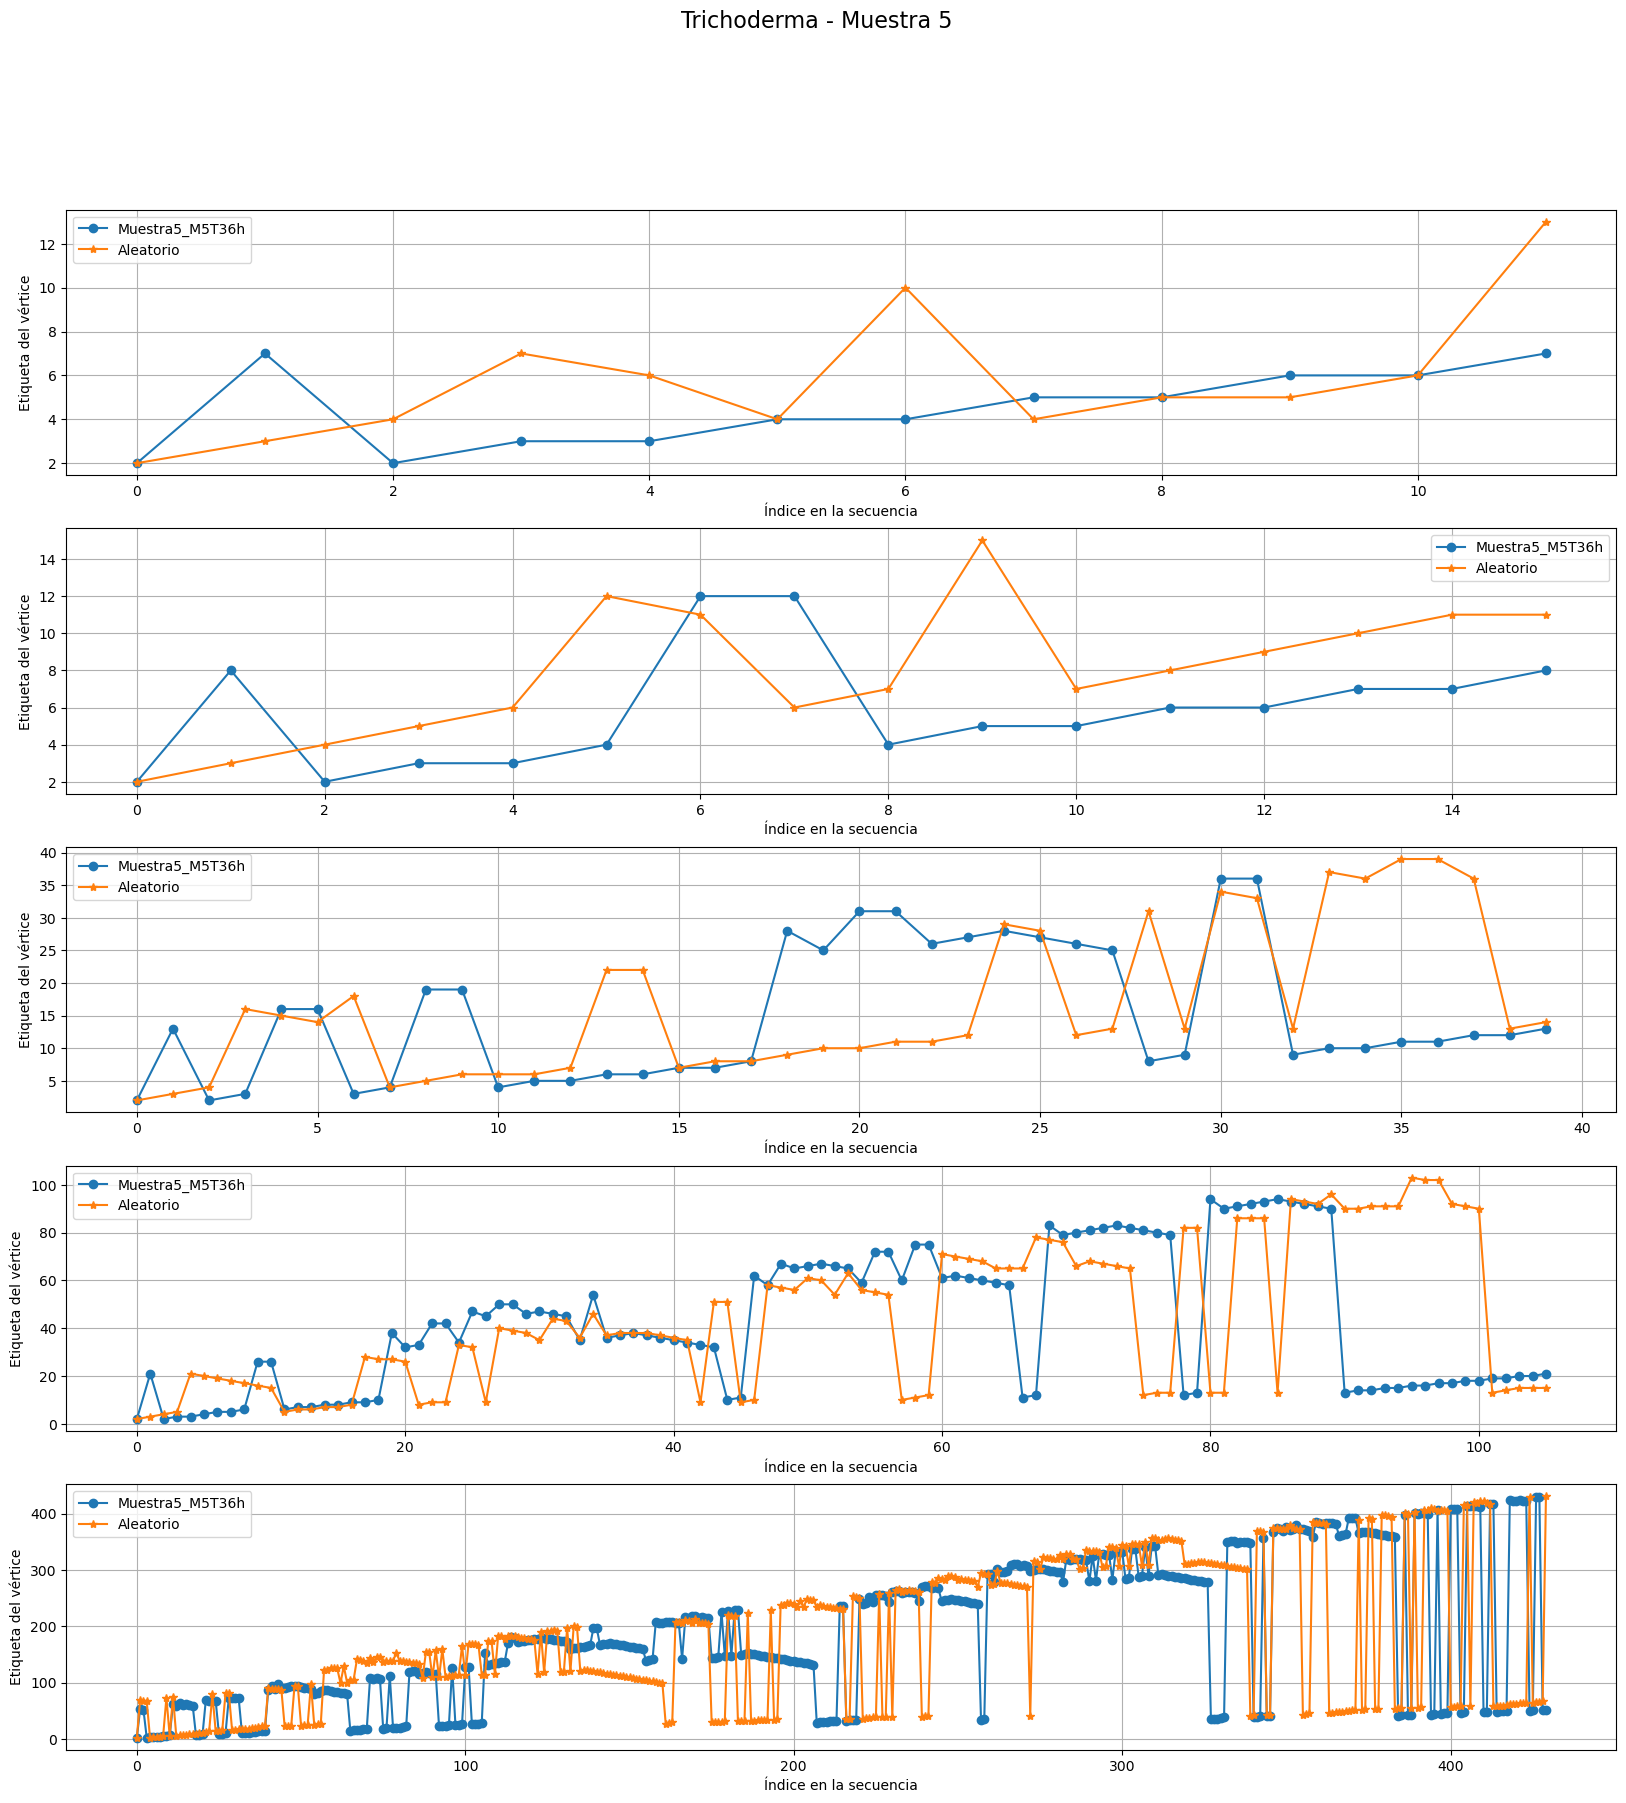

In [75]:
for muestra in range(1,6):
    prufer_seq = list()
    for red in REDES_TRICHODERMA[muestra]:
        G = nx.read_gexf(PATH_TRICHODERMA + red + ".gexf")
        print("**** Procesando red:", red, "con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        ps_miscelio = compute_prufer(G)
        # Procesa árbol aleatorio
        n = G.number_of_nodes()
        R = nx.generators.random_tree(n)
        print("**** Procesando árbol aleatorio con", R.number_of_nodes(), "nodos y", R.number_of_edges(), "aristas.")
        ps_aletorio = compute_prufer(R)
        prufer_seq.append([ps_miscelio, ps_aletorio])
        # Para dibujar el árbol
        # pos = {n:(G.nodes[n]['x'],G.nodes[n]['y']) for n in G.nodes()}
        #dibujar_arbol(G, red,pos, node_labels)
    muestra_secuencias(prufer_seq, [red, "Aleatorio"], "Trichoderma - Muestra " + str(muestra), "Índice en la secuencia", "Etiqueta del vértice")


In [116]:
def get_degree_distribution(G):
    lista_grados = [d for _, d in G.degree()]

    # Contar cuántos nodos tienen cada grado
    conteo = Counter(lista_grados)

    # Obtener el grado máximo
    grado_max = max(lista_grados)

    # Rellenar grados faltantes con 0
    for g in range(grado_max + 1):
        if g not in conteo:
            conteo[g] = 0

    # Ordenar por grado
    conteo_ordenado = dict(sorted(conteo.items()))
    return conteo_ordenado


In [121]:
def muestra_distribuciones(distribuciones, etiquetas, titulo, xlabel, ylabel):
    # Crear figura y ejes en una cuadrícula 2x2
    fig, axes = plt.subplots(len(distribuciones),1, figsize=(10, 20))
    for i, seq in enumerate(distribuciones):
        grados1 = list(seq[0].keys())
        frecuencias = list(seq[0].values())
        axes[i].scatter(grados1, frecuencias, label=etiquetas[0], marker="o")
        grados2 = list(seq[1].keys())
        frecuencias = list(seq[1].values())
        axes[i].scatter(grados2, frecuencias, label=etiquetas[1], marker="*")
        max_degree = max(max(grados1), max(grados2))
        axes[i].set_xticks(range(0, max_degree+1))
        #axes[i].plot(seq[0], label=etiquetas[0], marker="o", linestyle="-")
        #axes[i].plot(seq[1], label=etiquetas[1], marker="*", linestyle="-")
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(titulo, fontsize=16)
    fig.show()

**** Procesando red: Muestra1_M1N17h con 42 nodos y 41 aristas.
**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
Distribucion miscelio: {0: 0, 1: 22, 2: 0, 3: 20}
Distribucion aleatorio: {0: 0, 1: 18, 2: 16, 3: 3, 4: 3, 5: 1, 6: 1}
**** Procesando red: Muestra1_M1N18h con 54 nodos y 53 aristas.
**** Procesando árbol aleatorio con 54 nodos y 53 aristas.
Distribucion miscelio: {0: 0, 1: 28, 2: 0, 3: 26}
Distribucion aleatorio: {0: 0, 1: 21, 2: 18, 3: 12, 4: 2, 5: 1}
**** Procesando red: Muestra1_M1N20h con 102 nodos y 101 aristas.
**** Procesando árbol aleatorio con 102 nodos y 101 aristas.
Distribucion miscelio: {0: 0, 1: 52, 2: 0, 3: 50}
Distribucion aleatorio: {0: 0, 1: 37, 2: 38, 3: 20, 4: 6, 5: 1}
**** Procesando red: Muestra1_M1N22h con 226 nodos y 225 aristas.
**** Procesando árbol aleatorio con 226 nodos y 225 aristas.
Distribucion miscelio: {0: 0, 1: 114, 2: 0, 3: 112}
Distribucion aleatorio: {0: 0, 1: 82, 2: 87, 3: 37, 4: 17, 5: 3}
**** Procesando red: Muestra1_M1N24h

/var/folders/gw/x5b6glr13clbt8md6003thh40000gn/T/ipykernel_70176/1217349276.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


**** Procesando red: Muestra4_M4N20h con 202 nodos y 202 aristas.
**** Procesando árbol aleatorio con 202 nodos y 201 aristas.
Distribucion miscelio: {0: 0, 1: 101, 2: 0, 3: 101}
Distribucion aleatorio: {0: 0, 1: 73, 2: 78, 3: 37, 4: 9, 5: 4, 6: 1}
**** Procesando red: Muestra4_M4N22h con 518 nodos y 528 aristas.
**** Procesando árbol aleatorio con 518 nodos y 517 aristas.
Distribucion miscelio: {0: 0, 1: 249, 2: 0, 3: 269}
Distribucion aleatorio: {0: 0, 1: 197, 2: 186, 3: 85, 4: 40, 5: 10}
**** Procesando red: Muestra4_M4N24h con 1578 nodos y 1657 aristas.
**** Procesando árbol aleatorio con 1578 nodos y 1577 aristas.
Distribucion miscelio: {0: 0, 1: 710, 2: 1, 3: 866, 4: 1}
Distribucion aleatorio: {0: 0, 1: 578, 2: 579, 3: 299, 4: 91, 5: 29, 6: 2}
**** Procesando red: Muestra5_M5N18h con 48 nodos y 47 aristas.
**** Procesando árbol aleatorio con 48 nodos y 47 aristas.
Distribucion miscelio: {0: 0, 1: 25, 2: 0, 3: 23}
Distribucion aleatorio: {0: 0, 1: 17, 2: 22, 3: 5, 4: 3, 5: 0, 6: 1

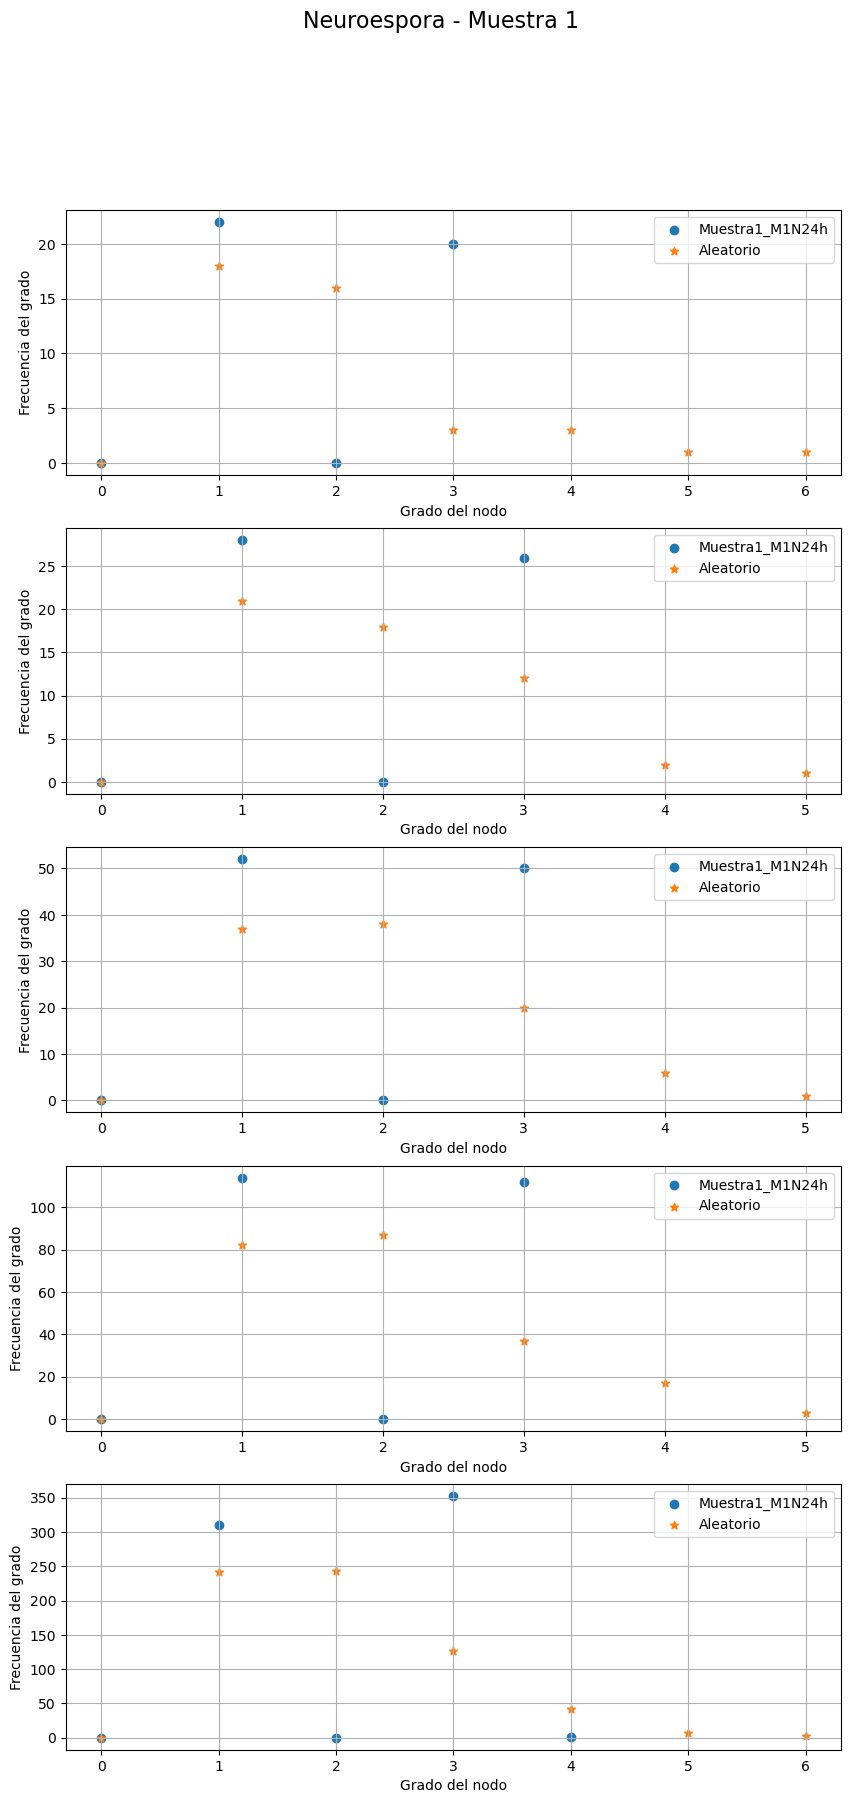

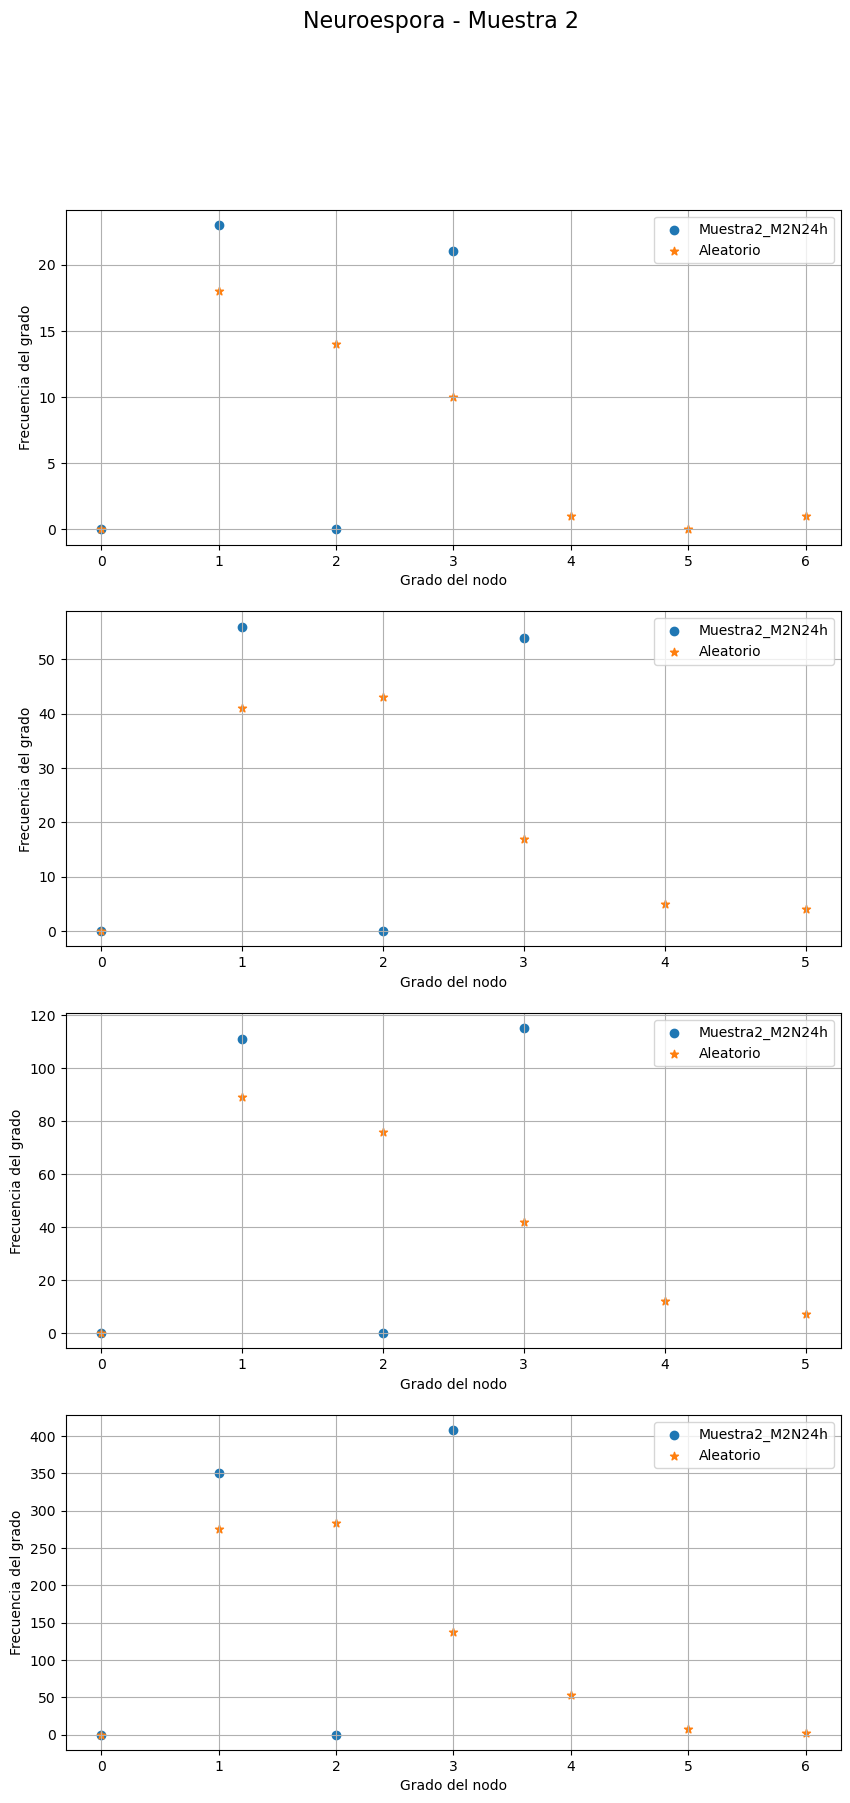

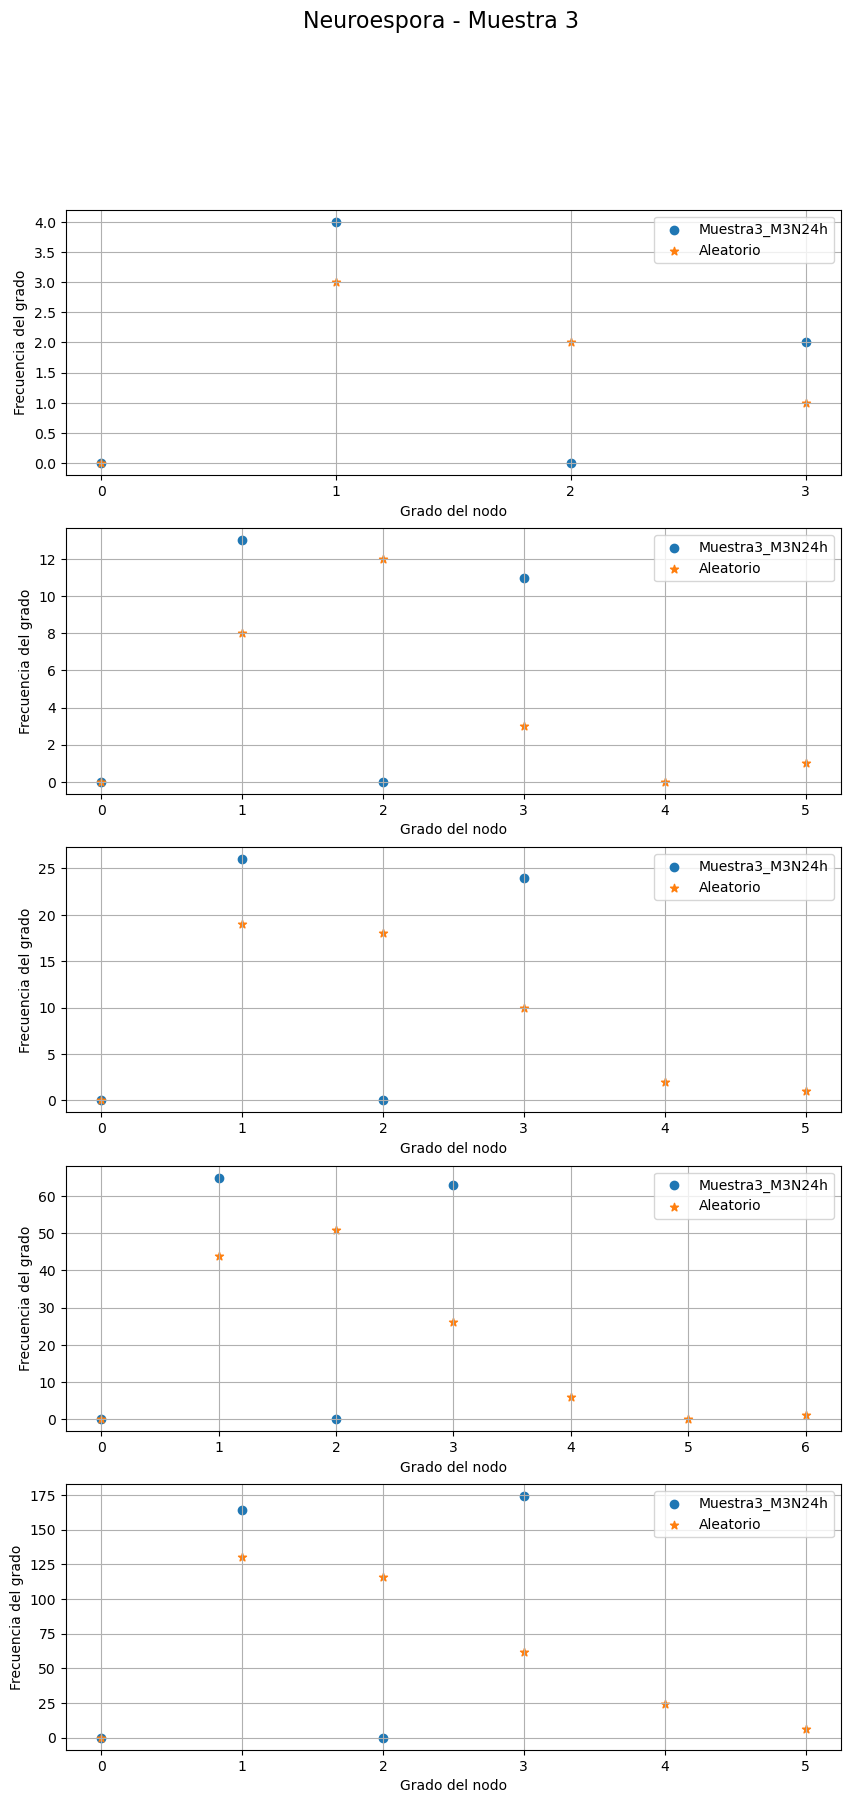

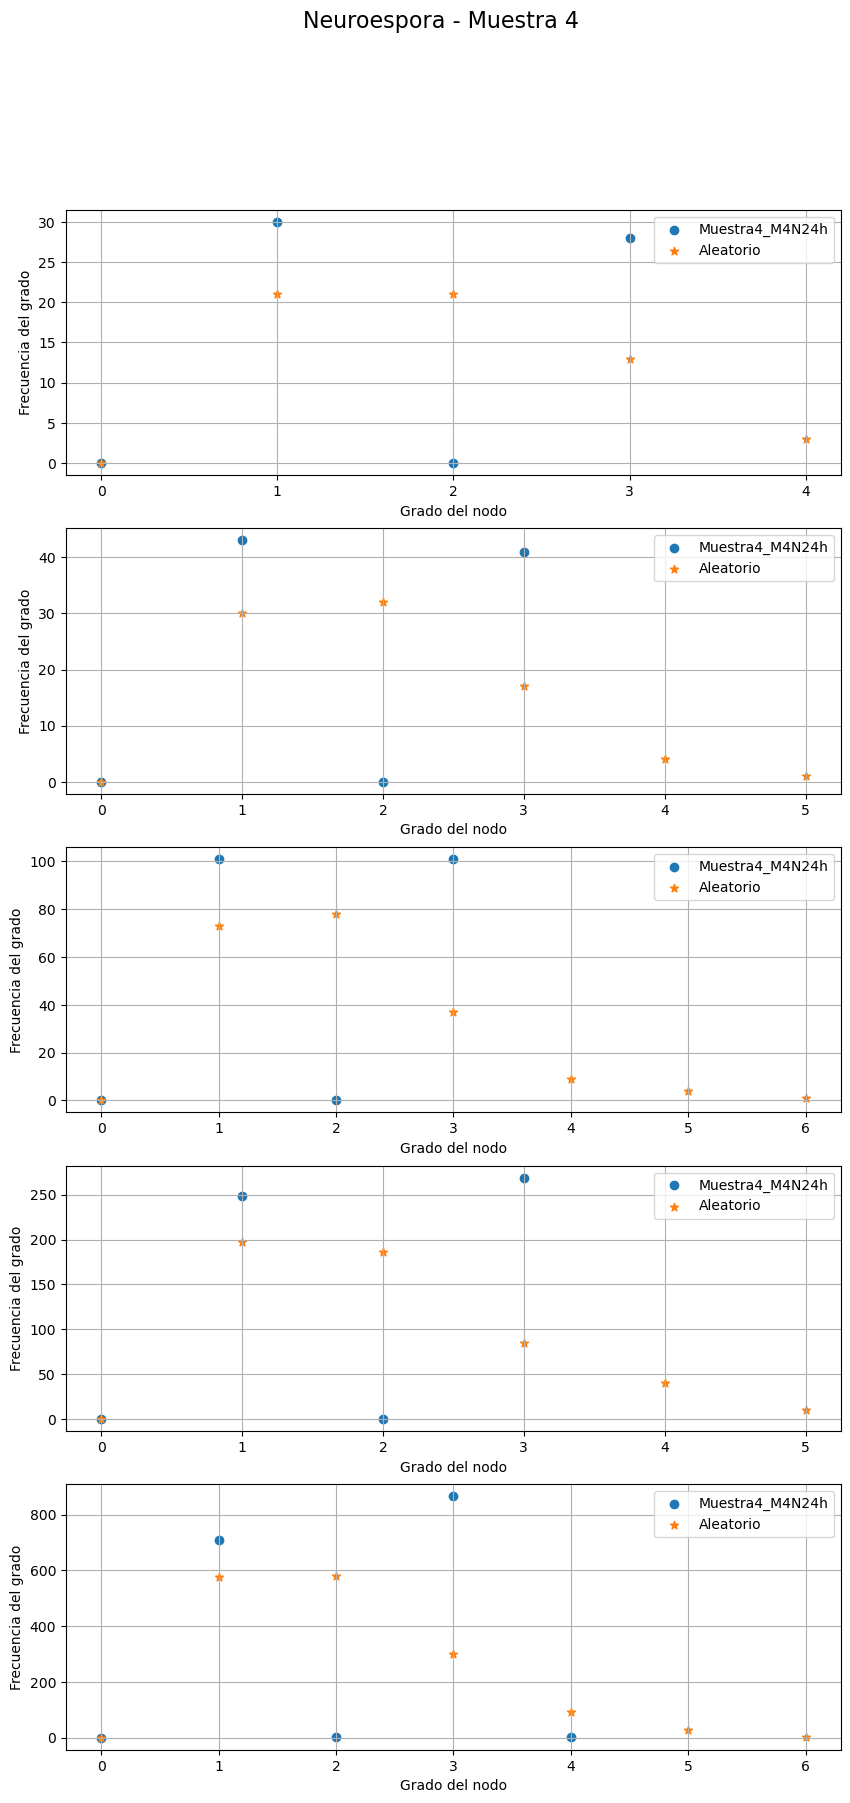

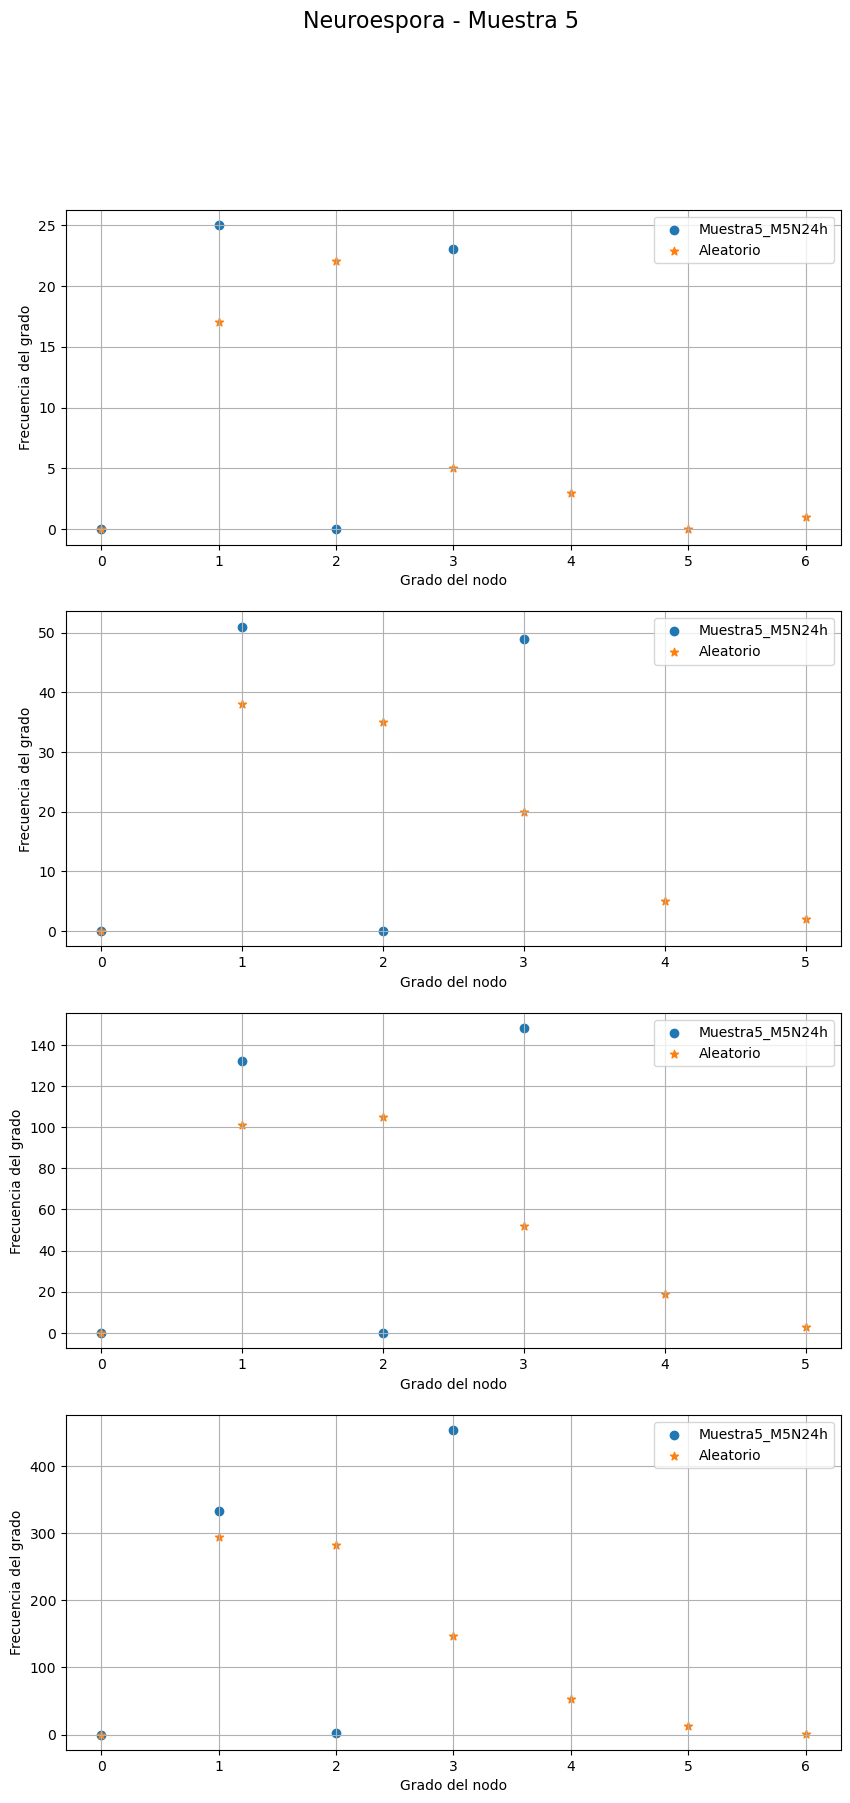

In [123]:
for muestra in range(1,6):
    grados_seq = list()
    for red in REDES_NEUROESPORA[muestra]:
        G = nx.read_gexf(PATH_NEUROESPORA + red + ".gexf")
        print("**** Procesando red:", red, "con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        degree_miscelio = get_degree_distribution(G)
        # Procesa árbol aleatorio
        n = G.number_of_nodes()
        R = nx.generators.random_tree(n)
        print("**** Procesando árbol aleatorio con", R.number_of_nodes(), "nodos y", R.number_of_edges(), "aristas.")
        degree_aletorio = get_degree_distribution(R)
        grados_seq.append([degree_miscelio, degree_aletorio])
        # Para dibujar el árbol
        # pos = {n:(G.nodes[n]['x'],G.nodes[n]['y']) for n in G.nodes()}
        #dibujar_arbol(G, red,pos, node_labels)
        print("Distribucion miscelio:", degree_miscelio)
        print("Distribucion aleatorio:", degree_aletorio)
    muestra_distribuciones(grados_seq, [red, "Aleatorio"], "Neuroespora - Muestra " + str(muestra), "Grado del nodo", "Frecuencia del grado")

# Diámetro

In [131]:
def muestra_diametro(diametro, etiquetas, titulo, xlabel, ylabel, xval):
    # Crear figura y ejes en una cuadrícula 2x2
    #fig = plt.subplots(len(diametro),1, figsize=(10, 20))
    plt.plot(xval, diametro[0], label=etiquetas[0], marker="o")
    plt.plot(xval, diametro[1], label=etiquetas[1], marker="*")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)  # Rota etiquetas del eje X
    plt.title(titulo)
    plt.legend()  # Muestra las etiquetas
    plt.show()


**** Procesando red: Muestra1_M1T24h con 24 nodos y 24 aristas.
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
**** Procesando red: Muestra1_M1T26h con 68 nodos y 70 aristas.
**** Procesando árbol aleatorio con 68 nodos y 67 aristas.
**** Procesando red: Muestra1_M1T28h con 84 nodos y 86 aristas.
**** Procesando árbol aleatorio con 84 nodos y 83 aristas.
**** Procesando red: Muestra1_M1T30h con 148 nodos y 152 aristas.
**** Procesando árbol aleatorio con 148 nodos y 147 aristas.
**** Procesando red: Muestra1_M1T32h con 294 nodos y 314 aristas.
**** Procesando árbol aleatorio con 294 nodos y 293 aristas.
Diametro miscelio: [11, 22, 26, 29, 40]
Diametri aleatorio: [12, 25, 32, 45, 46]


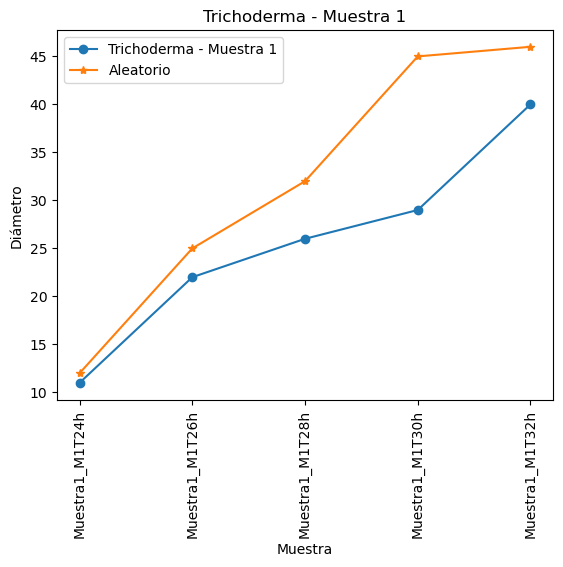

**** Procesando red: Muestra2_M2T24h con 8 nodos y 7 aristas.
**** Procesando árbol aleatorio con 8 nodos y 7 aristas.
**** Procesando red: Muestra2_M2T26h con 16 nodos y 15 aristas.
**** Procesando árbol aleatorio con 16 nodos y 15 aristas.
**** Procesando red: Muestra2_M2T28h con 24 nodos y 23 aristas.
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
**** Procesando red: Muestra2_M2T30h con 62 nodos y 62 aristas.
**** Procesando árbol aleatorio con 62 nodos y 61 aristas.
**** Procesando red: Muestra2_M2T32h con 150 nodos y 159 aristas.
**** Procesando árbol aleatorio con 150 nodos y 149 aristas.
Diametro miscelio: [4, 7, 9, 18, 29]
Diametri aleatorio: [4, 9, 15, 19, 31]


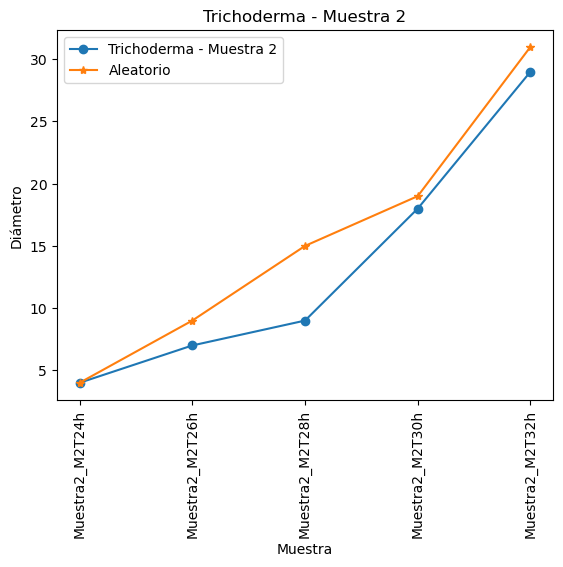

**** Procesando red: Muestra3_M3T26h con 14 nodos y 13 aristas.
**** Procesando árbol aleatorio con 14 nodos y 13 aristas.
**** Procesando red: Muestra3_M3T28h con 42 nodos y 41 aristas.
**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
**** Procesando red: Muestra3_M3T30h con 68 nodos y 68 aristas.
**** Procesando árbol aleatorio con 68 nodos y 67 aristas.
**** Procesando red: Muestra3_M3T32h con 160 nodos y 178 aristas.
**** Procesando árbol aleatorio con 160 nodos y 159 aristas.
**** Procesando red: Muestra3_M3T34h con 356 nodos y 403 aristas.
**** Procesando árbol aleatorio con 356 nodos y 355 aristas.
**** Procesando red: Muestra3_M3T36h con 788 nodos y 953 aristas.
**** Procesando árbol aleatorio con 788 nodos y 787 aristas.
Diametro miscelio: [6, 13, 19, 30, 40, 57]
Diametri aleatorio: [8, 16, 29, 43, 69, 79]


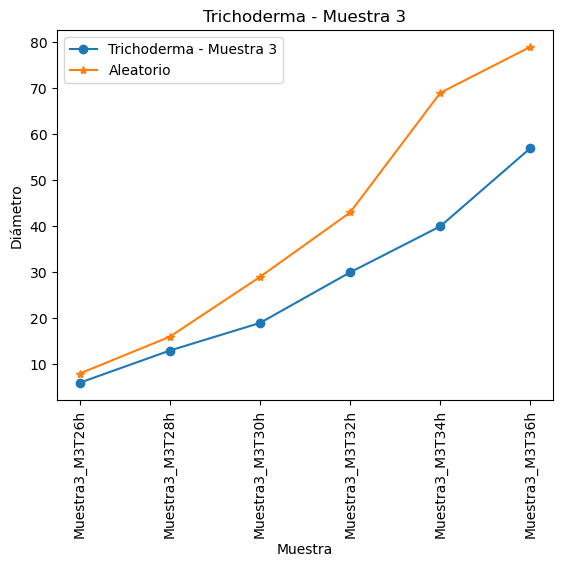

**** Procesando red: Muestra4_M4T26h con 18 nodos y 17 aristas.
**** Procesando árbol aleatorio con 18 nodos y 17 aristas.
**** Procesando red: Muestra4_M4T28h con 24 nodos y 23 aristas.
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
**** Procesando red: Muestra4_M4T30h con 50 nodos y 50 aristas.
**** Procesando árbol aleatorio con 50 nodos y 49 aristas.
**** Procesando red: Muestra4_M4T32h con 104 nodos y 106 aristas.
**** Procesando árbol aleatorio con 104 nodos y 103 aristas.
**** Procesando red: Muestra4_M4T34h con 268 nodos y 288 aristas.
**** Procesando árbol aleatorio con 268 nodos y 267 aristas.
**** Procesando red: Muestra4_M4T36h con 606 nodos y 675 aristas.
**** Procesando árbol aleatorio con 606 nodos y 605 aristas.
Diametro miscelio: [8, 10, 15, 28, 41, 57]
Diametri aleatorio: [8, 12, 16, 30, 42, 65]


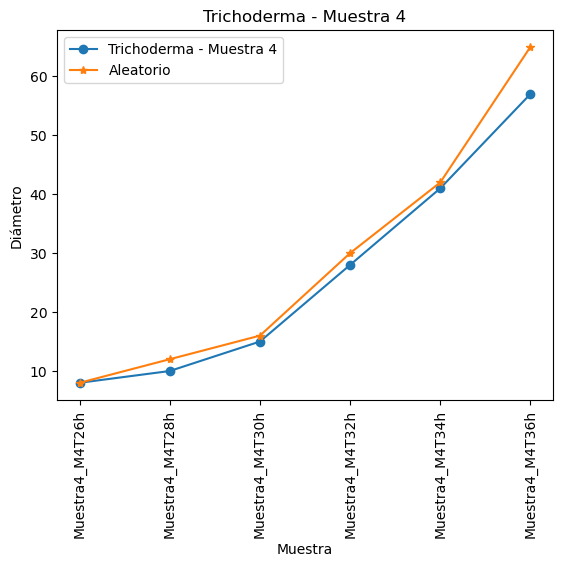

**** Procesando red: Muestra5_M5T26h con 14 nodos y 13 aristas.
**** Procesando árbol aleatorio con 14 nodos y 13 aristas.
**** Procesando red: Muestra5_M5T28h con 18 nodos y 17 aristas.
**** Procesando árbol aleatorio con 18 nodos y 17 aristas.
**** Procesando red: Muestra5_M5T30h con 42 nodos y 41 aristas.
**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
**** Procesando red: Muestra5_M5T32h con 108 nodos y 108 aristas.
**** Procesando árbol aleatorio con 108 nodos y 107 aristas.
**** Procesando red: Muestra5_M5T36h con 432 nodos y 476 aristas.
**** Procesando árbol aleatorio con 432 nodos y 431 aristas.
Diametro miscelio: [7, 8, 13, 21, 35]
Diametri aleatorio: [6, 12, 15, 28, 58]


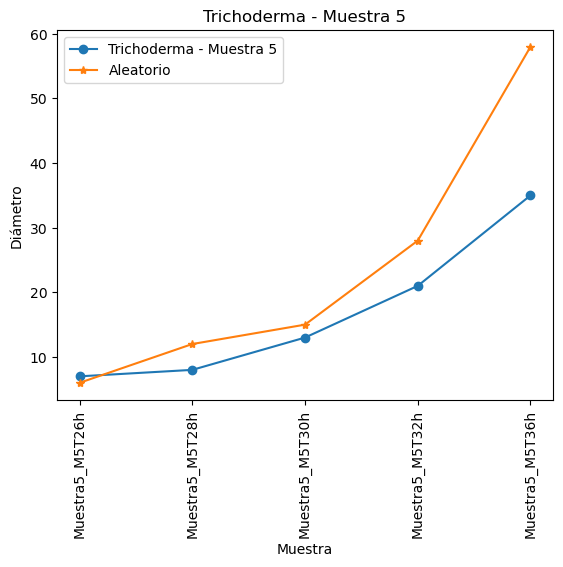

In [133]:
for muestra in range(1,6):
    diametro_miscelio = list()
    diametro_aleatorio = list()
    for red in REDES_TRICHODERMA[muestra]:
        G = nx.read_gexf(PATH_TRICHODERMA + red + ".gexf")
        print("**** Procesando red:", red, "con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        diametro = nx.diameter(G)
        diametro_miscelio.append(diametro)
        # Procesa árbol aleatorio
        n = G.number_of_nodes()
        R = nx.generators.random_tree(n)
        print("**** Procesando árbol aleatorio con", R.number_of_nodes(), "nodos y", R.number_of_edges(), "aristas.")
        diametro = nx.diameter(R)
        diametro_aleatorio.append(diametro)
    print("Diametro miscelio:", diametro_miscelio)
    print("Diametri aleatorio:", diametro_aleatorio)
    muestra_diametro([diametro_miscelio,diametro_aleatorio], ["Trichoderma - Muestra " + str(muestra), "Aleatorio"], "Trichoderma - Muestra " + str(muestra), "Muestra", "Diámetro", REDES_TRICHODERMA[muestra])